
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [48]:
import numpy as np

In [49]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [50]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [51]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [52]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [53]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)/values/logits
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [54]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [55]:
def model_loss(states,  actions, nextQs, gamma, # model input data 
               action_size, hidden_size): # model init
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Current reward or Rt/rt
    # Calculating rewards/Rs as prob/sigmoid of Qs, i.e. between 0-1
    qs = tf.sigmoid(Qs) # qt
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    #targetQs = qs + (0.99 * nextQs)
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss, qs, Qs

In [56]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [57]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.qs, self.Qs = model_loss(
            action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [58]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [59]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [60]:
train_episodes = 250           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [61]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [62]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [63]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
mean_qs_list, std_qs_list = [], []
mean_Qs_list, std_Qs_list = [], []
mean_nextQs_list, std_nextQs_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        mean_qs, std_qs = 0, 0
        mean_Qs, std_Qs = 0, 0
        mean_nextQs, std_nextQs = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training mean qs: {:.4f}'.format(np.mean(qs)),
                      'Training std qs: {:.4f}'.format(np.std(qs)),
                      'Training mean Qs: {:.4f}'.format(np.mean(Qs)),
                      'Training std Qs: {:.4f}'.format(np.std(Qs)),
                      'Training mean nextQs: {:.4f}'.format(np.mean(nextQs)),
                      'Training std nextQs: {:.4f}'.format(np.std(nextQs)),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                mean_qs_list.append((ep, np.mean(qs)))
                std_qs_list.append((ep, np.std(qs)))
                mean_Qs_list.append((ep, np.mean(Qs)))
                std_Qs_list.append((ep, np.std(Qs)))
                mean_nextQs_list.append((ep, np.mean(nextQs)))
                std_nextQs_list.append((ep, np.std(nextQs)))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1) # boolean

            # Calculating nextQt/future rewards: Qt = Rs + (gamma * nextQs)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - episode_ends.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            #nextQs = next_actions_logits * next_actions_mask
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.nextQs: nextQs}
            Qs, qs, q_loss, _ = sess.run([model.Qs, model.qs, model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 10.0 Training mean qs: 0.5478 Training std qs: 0.0623 Training mean Qs: 0.1964 Training std Qs: 0.2598 Training mean nextQs: 0.3907 Training std nextQs: 0.2211 Training q_loss: 0.6218 Explore P: 0.9990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 8.0 Training mean qs: 0.5939 Training std qs: 0.0866 Training mean Qs: 0.3987 Training std Qs: 0.3896 Training mean nextQs: 0.6586 Training std nextQs: 0.3583 Training q_loss: 0.8780 Explore P: 0.9982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 20.0 Training mean qs: 0.7640 Training std qs: 0.1065 Training mean Qs: 1.2792 Training std Qs: 0.6412 Training mean nextQ

-------------------------------------------------------------------------------
Episode: 21 Total reward: 28.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training mean Qs: 82.8041 Training std Qs: 23.9164 Training mean nextQs: 82.5205 Training std nextQs: 26.9301 Training q_loss: 120.9774 Explore P: 0.9534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 22 Total reward: 16.0 Training mean qs: 0.9997 Training std qs: 0.0036 Training mean Qs: 76.8622 Training std Qs: 20.9616 Training mean nextQs: 75.3421 Training std nextQs: 24.6153 Training q_loss: 224.2098 Explore P: 0.9519
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 23 Total reward: 17.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 76.5179 Training std Qs: 17.5234 T

-------------------------------------------------------------------------------
Episode: 43 Total reward: 32.0 Training mean qs: 0.9972 Training std qs: 0.0354 Training mean Qs: 57.5063 Training std Qs: 19.6374 Training mean nextQs: 57.7865 Training std nextQs: 22.0441 Training q_loss: 64.2485 Explore P: 0.9084
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44 Total reward: 41.0 Training mean qs: 0.9891 Training std qs: 0.0709 Training mean Qs: 58.3772 Training std Qs: 21.3434 Training mean nextQs: 58.1465 Training std nextQs: 23.9838 Training q_loss: 122.4742 Explore P: 0.9047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 45 Total reward: 15.0 Training mean qs: 0.9987 Training std qs: 0.0184 Training mean Qs: 61.3228 Training std Qs: 19.6473 Tr

-------------------------------------------------------------------------------
Episode: 64 Total reward: 40.0 Training mean qs: 0.9875 Training std qs: 0.0781 Training mean Qs: 94.9273 Training std Qs: 34.2472 Training mean nextQs: 95.8806 Training std nextQs: 37.0379 Training q_loss: 182.5966 Explore P: 0.8595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 65 Total reward: 29.0 Training mean qs: 0.9934 Training std qs: 0.0537 Training mean Qs: 104.3110 Training std Qs: 33.0465 Training mean nextQs: 105.0622 Training std nextQs: 36.9644 Training q_loss: 157.8207 Explore P: 0.8571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 66 Total reward: 28.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 113.0836 Training std Qs: 30.917

-------------------------------------------------------------------------------
Episode: 86 Total reward: 61.0 Training mean qs: 0.9800 Training std qs: 0.0980 Training mean Qs: 425.0300 Training std Qs: 165.3703 Training mean nextQs: 432.2866 Training std nextQs: 170.5556 Training q_loss: 668.6620 Explore P: 0.7998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 87 Total reward: 56.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 523.6938 Training std Qs: 154.2631 Training mean nextQs: 538.5565 Training std nextQs: 175.7066 Training q_loss: 5864.8867 Explore P: 0.7954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 88 Total reward: 56.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 709.6412 Training std Qs:

-------------------------------------------------------------------------------
Episode: 107 Total reward: 66.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 1769.5637 Training std Qs: 496.9269 Training mean nextQs: 1790.4424 Training std nextQs: 550.6999 Training q_loss: 25652.2422 Explore P: 0.7359
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 12.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 1952.3500 Training std Qs: 477.9048 Training mean nextQs: 1963.8042 Training std nextQs: 545.7179 Training q_loss: 27883.5000 Explore P: 0.7350
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 89.0 Training mean qs: 0.9900 Training std qs: 0.0700 Training mean Qs: 2312.7471 Train

-------------------------------------------------------------------------------
Episode: 128 Total reward: 142.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 36920.4219 Training std Qs: 9574.9941 Training mean nextQs: 37233.9766 Training std nextQs: 10733.1709 Training q_loss: 10035414.0000 Explore P: 0.6248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 129 Total reward: 71.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 40561.5938 Training std Qs: 9175.9375 Training mean nextQs: 41079.3164 Training std nextQs: 10221.0977 Training q_loss: 6867850.0000 Explore P: 0.6205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 130 Total reward: 41.0 Training mean qs: 0.9900 Training std qs: 0.0700 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 148 Total reward: 199.0 Training mean qs: 0.9925 Training std qs: 0.0608 Training mean Qs: 132555.2812 Training std Qs: 27843.2363 Training mean nextQs: 133926.3750 Training std nextQs: 30621.6055 Training q_loss: 49582416.0000 Explore P: 0.5043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 149 Total reward: 162.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training mean Qs: 130311.9609 Training std Qs: 34211.5195 Training mean nextQs: 131389.7344 Training std nextQs: 36867.7656 Training q_loss: 76085328.0000 Explore P: 0.4963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 150 Total reward: 167.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training

-------------------------------------------------------------------------------
Episode: 168 Total reward: 199.0 Training mean qs: 0.9875 Training std qs: 0.0781 Training mean Qs: 139334.2031 Training std Qs: 40692.6680 Training mean nextQs: 140810.7188 Training std nextQs: 42809.7695 Training q_loss: 26011354.0000 Explore P: 0.3586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 199.0 Training mean qs: 0.9900 Training std qs: 0.0700 Training mean Qs: 135243.2188 Training std Qs: 33434.8477 Training mean nextQs: 137085.2344 Training std nextQs: 33522.2227 Training q_loss: 20416770.0000 Explore P: 0.3517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 170 Total reward: 199.0 Training mean qs: 0.9875 Training std qs: 0.0781 Training

-------------------------------------------------------------------------------
Episode: 188 Total reward: 199.0 Training mean qs: 0.9325 Training std qs: 0.1709 Training mean Qs: 46156.2109 Training std Qs: 24325.6543 Training mean nextQs: 40473.3477 Training std nextQs: 41694.1680 Training q_loss: 625202240.0000 Explore P: 0.2456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 189 Total reward: 199.0 Training mean qs: 0.9425 Training std qs: 0.1595 Training mean Qs: 42479.2148 Training std Qs: 22639.3867 Training mean nextQs: 38380.8711 Training std nextQs: 35162.4102 Training q_loss: 335803584.0000 Explore P: 0.2410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 190 Total reward: 191.0 Training mean qs: 0.9300 Training std qs: 0.1735 Training m

-------------------------------------------------------------------------------
Episode: 208 Total reward: 177.0 Training mean qs: 0.7700 Training std qs: 0.2492 Training mean Qs: 17815.1660 Training std Qs: 19297.9863 Training mean nextQs: -51961.3438 Training std nextQs: 141964.4375 Training q_loss: 21711900672.0000 Explore P: 0.1808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 199.0 Training mean qs: 0.7875 Training std qs: 0.2472 Training mean Qs: 15472.3867 Training std Qs: 15329.9023 Training mean nextQs: -47288.7812 Training std nextQs: 136941.2500 Training q_loss: 20117721088.0000 Explore P: 0.1775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 199.0 Training mean qs: 0.7550 Training std qs: 0.2499 Tr

-------------------------------------------------------------------------------
Episode: 228 Total reward: 199.0 Training mean qs: 0.8050 Training std qs: 0.2439 Training mean Qs: 11171.1191 Training std Qs: 9982.2920 Training mean nextQs: -37669.4062 Training std nextQs: 126699.0703 Training q_loss: 16896304128.0000 Explore P: 0.1247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 229 Total reward: 199.0 Training mean qs: 0.8125 Training std qs: 0.2421 Training mean Qs: 12622.8320 Training std Qs: 10576.2510 Training mean nextQs: -31204.7520 Training std nextQs: 113304.5781 Training q_loss: 13266980864.0000 Explore P: 0.1225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 230 Total reward: 199.0 Training mean qs: 0.8325 Training std qs: 0.2360 Tra

-------------------------------------------------------------------------------
Episode: 248 Total reward: 199.0 Training mean qs: 0.8450 Training std qs: 0.2312 Training mean Qs: 9360.2441 Training std Qs: 7176.6284 Training mean nextQs: -25303.8145 Training std nextQs: 92820.1484 Training q_loss: 8932654080.0000 Explore P: 0.0871
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 249 Total reward: 199.0 Training mean qs: 0.9100 Training std qs: 0.1921 Training mean Qs: 18454.7969 Training std Qs: 9708.6650 Training mean nextQs: 300.8806 Training std nextQs: 75281.2734 Training q_loss: 5118041600.0000 Explore P: 0.0856
-------------------------------------------------------------------------------


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0.5,0,'Episode')

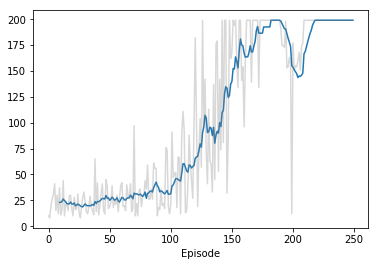

In [65]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0.5,0,'Episode')

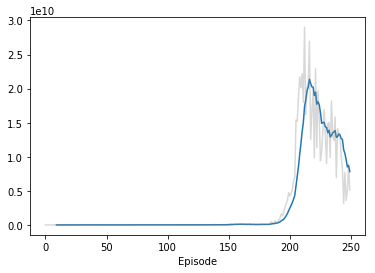

In [66]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

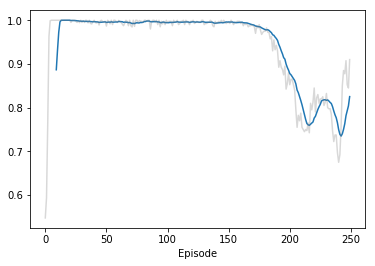

In [67]:
eps, arr = np.array(mean_qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

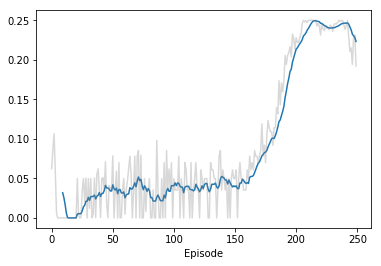

In [68]:
eps, arr = np.array(std_qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

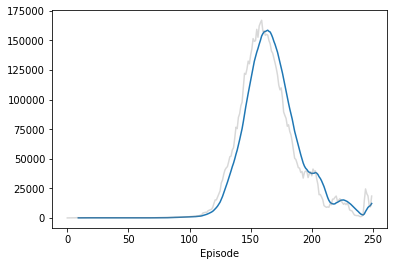

In [69]:
eps, arr = np.array(mean_Qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

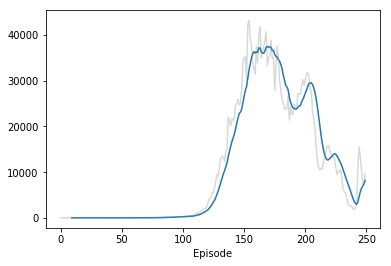

In [70]:
eps, arr = np.array(std_Qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

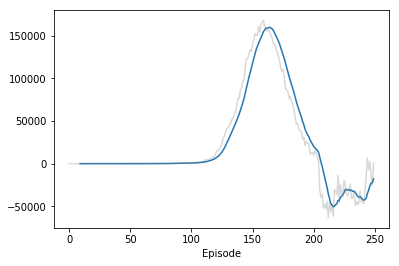

In [71]:
eps, arr = np.array(mean_nextQs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

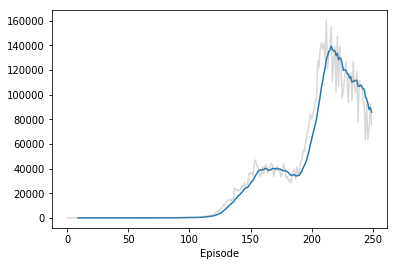

In [72]:
eps, arr = np.array(std_nextQs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [26]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.